Copyright @ cb_park@korea.ac.kr (Cheonbok Park), jihyeonlee@kaist.ac.kr (Jihyeon Lee)

## Import libraries

In [84]:
import time
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision 
import torchvision.transforms as transforms
from nltk.translate.bleu_score import corpus_bleu
from torch.nn.utils.rnn import pack_padded_sequence
import h5py
import numpy as np
import matplotlib.pyplot as plt
import json
import os 



## Exploring the data we will use today

---

<For further information about visualdata, please refer to the websites written below\>

http://cocodataset.org/#explore

https://www.visualdata.io/

In [25]:
# root_dir = '/home/nas1_userE/jihyeonlee/ds_data'
# json_data = open(os.path.join(root_dir, 'dataset_coco.json')).read()
# data = json.loads(json_data)
# print(data["images"][0])
# print()
# print(data["images"][1])

In [26]:
# json_data = open(os.path.join(root_dir,'dataset_flickr30k.json')).read()
# data = json.loads(json_data)
# print(data["images"][0])
# print()
# print(data["images"][1])

In [27]:
json_data = open(os.path.join(root_dir,'dataset_flickr8k.json')).read()
data = json.loads(json_data)
print(data["images"][0])
print()
print(data["images"][1])

{'sentids': [0, 1, 2, 3, 4], 'imgid': 0, 'sentences': [{'tokens': ['a', 'black', 'dog', 'is', 'running', 'after', 'a', 'white', 'dog', 'in', 'the', 'snow'], 'raw': 'A black dog is running after a white dog in the snow .', 'imgid': 0, 'sentid': 0}, {'tokens': ['black', 'dog', 'chasing', 'brown', 'dog', 'through', 'snow'], 'raw': 'Black dog chasing brown dog through snow', 'imgid': 0, 'sentid': 1}, {'tokens': ['two', 'dogs', 'chase', 'each', 'other', 'across', 'the', 'snowy', 'ground'], 'raw': 'Two dogs chase each other across the snowy ground .', 'imgid': 0, 'sentid': 2}, {'tokens': ['two', 'dogs', 'play', 'together', 'in', 'the', 'snow'], 'raw': 'Two dogs play together in the snow .', 'imgid': 0, 'sentid': 3}, {'tokens': ['two', 'dogs', 'running', 'through', 'a', 'low', 'lying', 'body', 'of', 'water'], 'raw': 'Two dogs running through a low lying body of water .', 'imgid': 0, 'sentid': 4}], 'split': 'train', 'filename': '2513260012_03d33305cf.jpg'}

{'sentids': [5, 6, 7, 8, 9], 'imgid'

## Data Loader

In [31]:
class CaptionDataset(Dataset):
    """
    Inherit PyTorch Dataset class to use it as an input of PyTorch DataLoader.
    """

    def __init__(self, root_dir, file_name, split, transform=None):
        """
        :param root_dir: folder where data files are stored
        :param file_name: name of the processed dataset
        :param split: purpose of the data, one of the 'TRAIN', 'VAL', and 'TEST'
        :param transform: image transform pipeline
        """
        self.split = split
        assert self.split in {'TRAIN', 'VAL', 'TEST'}

        # Open hdf5 file where images are stored
        self.h = h5py.File(os.path.join(root_dir, self.split + '_IMAGES_' + file_name + '.hdf5'), 'r')
        self.imgs = self.h['images']

        # Captions per image
        self.cpi = self.h.attrs['captions_per_image']

        # Load encoded captions (completely into memory)
        with open(os.path.join(root_dir, self.split + '_CAPTIONS_' + file_name + '.json'), 'r') as j:
            self.captions = json.load(j)

        # Load caption lengths (completely into memory)
        with open(os.path.join(root_dir, self.split + '_CAPLENS_' + file_name + '.json'), 'r') as j:
            self.caplens = json.load(j)

        # PyTorch transformation pipeline for the image (normalizing, etc.)
        self.transform = transform

        # Total number of datapoints
        self.dataset_size = len(self.captions)

    def __getitem__(self, i):
        # Remember, the Nth caption corresponds to the (N // captions_per_image)th image
        img = torch.FloatTensor(self.imgs[i // self.cpi] / 255.)
        if self.transform is not None:
            img = self.transform(img)

        caption = torch.LongTensor(self.captions[i])

        caplen = torch.LongTensor([self.caplens[i]])

        if self.split is 'TRAIN':
            return img, caption, caplen
        else:
            # For validation and testing, also return all 'captions_per_image' captions to find BLEU-4 score
            all_captions = torch.LongTensor(
                self.captions[((i // self.cpi) * self.cpi):(((i // self.cpi) * self.cpi) + self.cpi)])
            return img, caption, caplen, all_captions

    def __len__(self):
        return self.dataset_size


In [32]:
        hf = h5py.File(os.path.join(root_dir, 'TEST' + '_IMAGES_' + 'flickr8k_5_cap_per_img_5_min_word_freq' + '.hdf5'), 'r')
        img = hf['images']

        # Captions per image
        cpi = hf.attrs['captions_per_image']

In [58]:
file_name = 'flickr8k_5_cap_per_img_5_min_word_freq'
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])
batch_size = 32
workers = 0
train_loader = torch.utils.data.DataLoader(
        CaptionDataset(root_dir, file_name, 'TRAIN', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
        CaptionDataset(root_dir, file_name, 'VAL', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

In [59]:
# Read word map
word_map_file = os.path.join(root_dir, 'WORDMAP_' + data_name + '.json')
with open(word_map_file, 'r') as j:
    word_map = json.load(j)
    rev_word_map = {v: k for k, v in word_map.items()}  # ix2word
    

In [60]:
len(rev_word_map)

2633

In [86]:
for i, (image, caption, caplen) in enumerate(train_loader):
    print(image.size())
    break

torch.Size([32, 3, 256, 256])


['<start>', 'a', 'dark', 'brown', 'dog', 'runs', 'behind', 'a', 'yellow', 'dog', 'in', 'the', 'grass', '<end>']
['<start>', 'a', 'man', 'rides', 'a', 'green', 'motorcycle', 'around', 'a', 'corner', '<end>']
['<start>', 'a', 'child', 'in', 'a', 'red', 'and', 'grey', 'coat', 'in', 'front', 'of', 'a', 'wooden', 'shed', '<end>']
['<start>', 'many', 'children', 'play', 'in', 'the', 'water', '<end>']
['<start>', 'a', 'group', 'of', 'men', 'playing', 'hockey', '<end>']
['<start>', 'a', 'young', 'boy', 'wearing', 'a', '<unk>', 'jersey', 'poses', 'on', 'a', 'toy', 'motorcycle', 'in', 'a', '<unk>', 'area', '<end>']


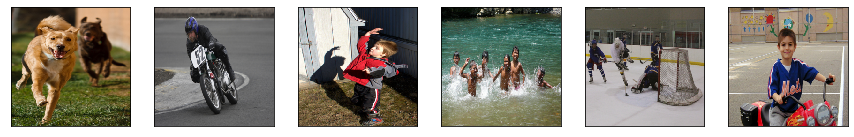

In [103]:
def show_images_captions(image, caption):
    
    index=np.random.choice(batch_size, 6)
    images =image.numpy()[index]
    captions = caption[index]
    plt.figure(figsize=(15,90))    
    for a in range(161, 167):    
        plt.subplot(a)
        plt.imshow(images[(a-161)].transpose(1,2,0))
        plt.xticks([])
        plt.yticks([])
        
        words = [rev_word_map[int(idx)] for idx in captions[(a-161)] if rev_word_map[int(idx)] != '<pad>']
        print(words)
    plt.show()
        

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)
        
for i, (image, caption, caplen) in enumerate(train_loader):
    show_images_captions(denorm(image), caption)
    break

## Dictionary and special tokens
---
word_map : word2idx

rev_word_map : idx2word

In [113]:
# Pad token
print(word_map['<pad>'])

0


In [116]:
# Start token
print(word_map['<start>'])

2631


In [117]:
# End token
print(word_map['<end>'])

2632


In [119]:
# Unknown token
print(word_map['<unk>'])

2630


## Utils

In [120]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [121]:

def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)*targets.size(1)
    _, ind = scores.topk(k, -1, True, True)
    ind = ind.view(-1,k)
    correct = ind.eq(targets.contiguous().view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

## Encoder Module 


![대체 텍스트](https://i.ibb.co/SdBynHr/encoder.png)

In [158]:

class Encoder(nn.Module):
    """
    Encoder.
    """

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size
        resnet = torchvision.models.resnet101(pretrained=True)  # pretrained ImageNet ResNet-101 # (ans)
        # Remove pooling and linear layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules) #variadic parameters
        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.fine_tune()

    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32) # ans
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size) #ans 
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

    def fine_tune(self, fine_tune=True):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.
        :param fine_tune: Allow?
        """
        for p in self.resnet.parameters():
            p.requires_grad = False #ans
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune


![대체 텍스트](https://i.ibb.co/ynGLnLN/decoder-no-att.png)

## Attention Module 

![대체 텍스트](https://i.ibb.co/ft5jfDP/att.png)

![대체 텍스트](https://i.stack.imgur.com/tiQkz.png)

![대체 텍스트](https://i.ibb.co/hMzn1Nj/weights.png)

In [123]:
class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image # ans 
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output #ans
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed #ans 
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        # (batch_size,num_pixels,attention_dim) + (batch_size,1,attention_dim) =>  linear projection to logit => (batch_size,num_pixels,1) => squeeze 
       
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        # (batch_size,1,num_pixels) (batch_size, num_pixels,encoder_dims) ==> bmm ==>(batch_size,1,encoder_dims) => (batch_size, encoder_dims)
        
        attention_weighted_encoding = alpha.unsqueeze(1).bmm(encoder_out).squeeze(1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha


## Decoder Module

![대체 텍스트](https://i.ibb.co/VwGN9k2/sorted.jpg)

### Decoder without Attention

In [124]:
class DecoderWithoutAttention(nn.Module):
    """
    Decoder.
    """

    def __init__(self, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithoutAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim, decoder_dim, bias=True)  # decoding LSTMCell # (ans)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell # (ans)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell # (ans)
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
    
    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim) #(ans)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim) #ans 

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim) #ans 

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            h, c = self.decode_step(embeddings[:batch_size_t, t, :],
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size) # (ans)
            predictions[:batch_size_t, t, :] = preds
            
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

![대체 텍스트](https://i.ibb.co/8bY63kr/decoder-att.png)

### Deocder With Attention

![대체 텍스트](https://i.ibb.co/mhzFfjW/model.png)

In [159]:
class DecoderWithAttention(nn.Module):
    """
    Decoder.
    """

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # Definded attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell # (ans)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell # (ans)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell # (ans)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
    
    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim) #(ans)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim) #ans 

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim) #ans 

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1), #ans
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size) # (ans)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

##  Options for training

In [128]:
#Model parameters
emb_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead


In [162]:
start_epoch = 0
epochs = 2  # number of epochs to train for (if early stopping is not triggered)
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
batch_size = 32
workers = 1  # for data-loading; right now, only 1 works with h5py
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.  # BLEU-4 score right now
print_freq = 100  # print training/validation stats every __ batches
fine_tune_encoder = False  # fine-tune encoder?
checkpoint = None  # path to checkpoint, None if none

#### Word Map

In [163]:
# with open(word_map_file, 'r') as j:
#   word_map = json.load(j)

#### Loss function

In [164]:
# Loss function
criterion = nn.CrossEntropyLoss(ignore_index=0).to(device)

#### Normalization

In [165]:
# normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                                  std=[0.5, 0.5, 0.5])
# train_loader = torch.utils.data.DataLoader(CaptionDataset(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize])),
#         batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
# val_loader = torch.utils.data.DataLoader(CaptionDataset(data_folder, data_name, 'VAL', transform=transforms.Compose([normalize])),
#         batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)


## Train & Validation Modules

### Training Module

In [166]:
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    """
    Performs one epoch's training.
    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number
    """

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    losses = AverageMeter()  # loss (per word decoded)
    top5accs = AverageMeter() 
    
    # Batches
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        
        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        
        # Calculate loss
        loss = criterion(scores.contiguous().view(-1,scores.size()[-1]), targets[:,:scores.size()[1]].contiguous().view(-1)) # #ans 
        
        # Alphas  (Batch_size,max_time_seq,pixel_size)
        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean() # ans 

        # Back prop.
        decoder_optimizer.zero_grad() # ans 
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward() # ans 

        
        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Keep track of metrics
        top5 = accuracy(scores, targets[:,:scores.size()[1]], 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        
        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader),
                                                                          loss=losses))

### Validation Module

In [167]:
def validate(val_loader, encoder, decoder, criterion):
    """
    Performs one epoch's validation.
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    # solves the issue #57
    with torch.no_grad():
        # Batches
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            
            # Calculate loss
            loss = criterion(scores.contiguous().view(-1,scores.size()[-1]), targets[:,:scores.size()[1]].contiguous().view(-1)) # #ans
            
            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets[:,:scores.size()[1]].contiguous(), 5)
            top5accs.update(top5, sum(decode_lengths))
            
            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(i, len(val_loader),loss=losses))

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

            
        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4


## Train & Validate on Decoder without attention model

In [143]:
decoder = DecoderWithoutAttention(embed_dim=emb_dim,
                                 decoder_dim=decoder_dim,
                                 vocab_size=len(word_map),
                                 dropout=dropout)
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
encoder = Encoder()
encoder.fine_tune(fine_tune_encoder)
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None


In [169]:
encoder = encoder.to(device)
deocder = decoder.to(device)

for epoch in range(epochs):
  if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
    adjust_learning_rate(decoder_optimizer,0.8)
  train(train_loader=train_loader,
       encoder = encoder,
       decoder = decoder,
       criterion = criterion,
       encoder_optimizer = encoder_optimizer, 
       decoder_optimizer = decoder_optimizer,
       epoch = epoch)
  recent_bleu4 = validate(val_loader = val_loader,
                          encoder = encoder,
                         decoder = decoder,
                         criterion = criterion)
  
 

Epoch: [0][0/938]	Loss 1.5345 (1.5345)	


KeyboardInterrupt: 

## Train & Validate on Decoder With Attention model

In [173]:
decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=emb_dim,
                                       decoder_dim=decoder_dim,
                                       vocab_size=len(word_map),
                                       dropout=dropout)
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
encoder = Encoder()
encoder.fine_tune(fine_tune_encoder)
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None


In [176]:
decoder = decoder.to(device)
encoder = encoder.to(device)

encoder.eval()
decoder.eval()

checkpoint_with = torch.load(os.path.join(root_dir,'withcheckpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar'))
# checkpoint_without = torch.load(os.path.join(root_dir,'dataset/withoutcheckpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar'), map_location='cuda:0')

encoder.load_state_dict(checkpoint_with['encoder'].state_dict())
decoder.load_state_dict(checkpoint_with['decoder'].state_dict())

# for epoch in range(epochs):
#   train(train_loader=train_loader,
#          encoder = encoder,
#          decoder = decoder,
#          criterion = criterion,
#          encoder_optimizer = encoder_optimizer, 
#          decoder_optimizer = decoder_optimizer,
#          epoch = epoch)


for epoch in range(epochs):
    recent_bleu4 = validate(val_loader = val_loader,
                          encoder = encoder,
                         decoder = decoder,
                         criterion = criterion)
  
# print(checkpoint)

# for epoch in range(epochs):
#   if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
#     adjust_learning_rate(decoder_optimizer,0.8)
#   train(train_loader=train_loader,
#        encoder = encoder,
#        decoder = decoder,
#        criterion = criterion,
#        encoder_optimizer = encoder_optimizer, 
#        decoder_optimizer = decoder_optimizer,
#        epoch = epoch)
#   recent_bleu4 = validate(val_loader = val_loader,
#                           encoder = encoder,
#                          decoder = decoder,
#                          criterion = criterion)

Validation: [0/157]	Loss 5.0274 (5.0274)	
Validation: [100/157]	Loss 4.8382 (4.6184)	

 * LOSS - 4.626, TOP-5 ACCURACY - 80.811, BLEU-4 - 0.13325094408532562

Validation: [0/157]	Loss 4.4091 (4.4091)	
Validation: [100/157]	Loss 4.6231 (4.6352)	

 * LOSS - 4.626, TOP-5 ACCURACY - 81.009, BLEU-4 - 0.13325094408532562



In [ ]:
def save_checkpoint(data_name, epoch,encoder, decoder, encoder_optimizer, decoder_optimizer):
    """
    Saves model checkpoint.
    :param data_name: base name of processed dataset
    :param epoch: epoch number
    :param encoder: encoder model
    :param decoder: decoder model
    :param encoder_optimizer: optimizer to update encoder's weights, if fine-tuning
    :param decoder_optimizer: optimizer to update decoder's weights
    """
    state = {'epoch': epoch,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer}
    filename = 'checkpoint_' + data_name + '.pth.tar'
    torch.save(state, filename)
    